<a href="https://colab.research.google.com/github/aagarwal17/datasci-207-arun/blob/main/06_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 6

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

``Objectives``

* This assignment connects all the pieces involved in training feed-forward fully connected neural networks (FFNN);

* You will run a full set of experiments to explore different hyperparameters and hidden layer sizes for two datasets, and then document your findings.

``Data``
* Digits MNIST
* Fashion MNIST

### Import libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

from keras.datasets import fashion_mnist
from keras.datasets import mnist

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

---
### Step 1: Data ingestion

In [2]:
# Load the Fashion MNIST dataset.
(X_train_fashion, Y_train_fashion), (X_test_fashion, Y_test_fashion) = fashion_mnist.load_data()

# Load the Digits MNIST dataset.
(X_train_digits, Y_train_digits), (X_test_digits, Y_test_digits) = mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


---
### Step 2: Data preprocessing

``Fashion MNIST``

In [3]:
# Normalize
X_train_fashion = X_train_fashion / 255.
X_test_fashion = X_test_fashion / 255.

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_fashion = Y_train_fashion.flatten()
Y_test_fashion = Y_test_fashion.flatten()

label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_fashion.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_fashion = X_train_fashion[shuffled_indices]
Y_train_fashion = Y_train_fashion[shuffled_indices]

``Digits MNIST``

In [4]:
# Normalize
X_train_digits = X_train_digits / 255.
X_test_digits = X_test_digits / 255.

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_digits = Y_train_digits.flatten()
Y_test_digits = Y_test_digits.flatten()

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_digits.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_digits = X_train_digits[shuffled_indices]
Y_train_digits = Y_train_digits[shuffled_indices]

---
### Step 3: Exploratory data analysis (EDA)

### <span style="color:chocolate">Exercise 1:</span> Getting to know your data (5 points)

Complete the following task:

1. Show the first training example in X_train_fashion;
2. Show the first training example in X_train_digits;
3. Display the first 5 images in X_train_digits for each class in Y_train_digits, arranged in a 10x5 grid.

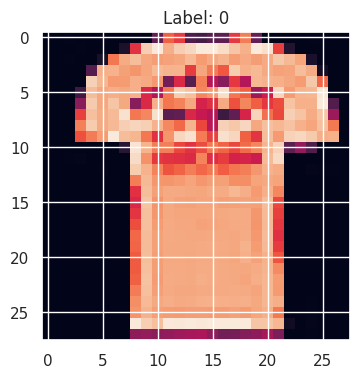

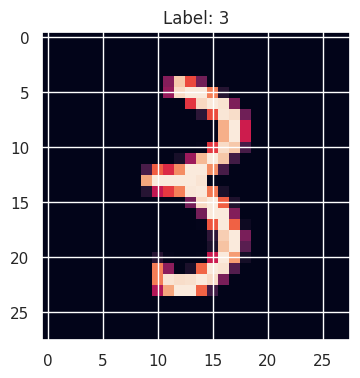

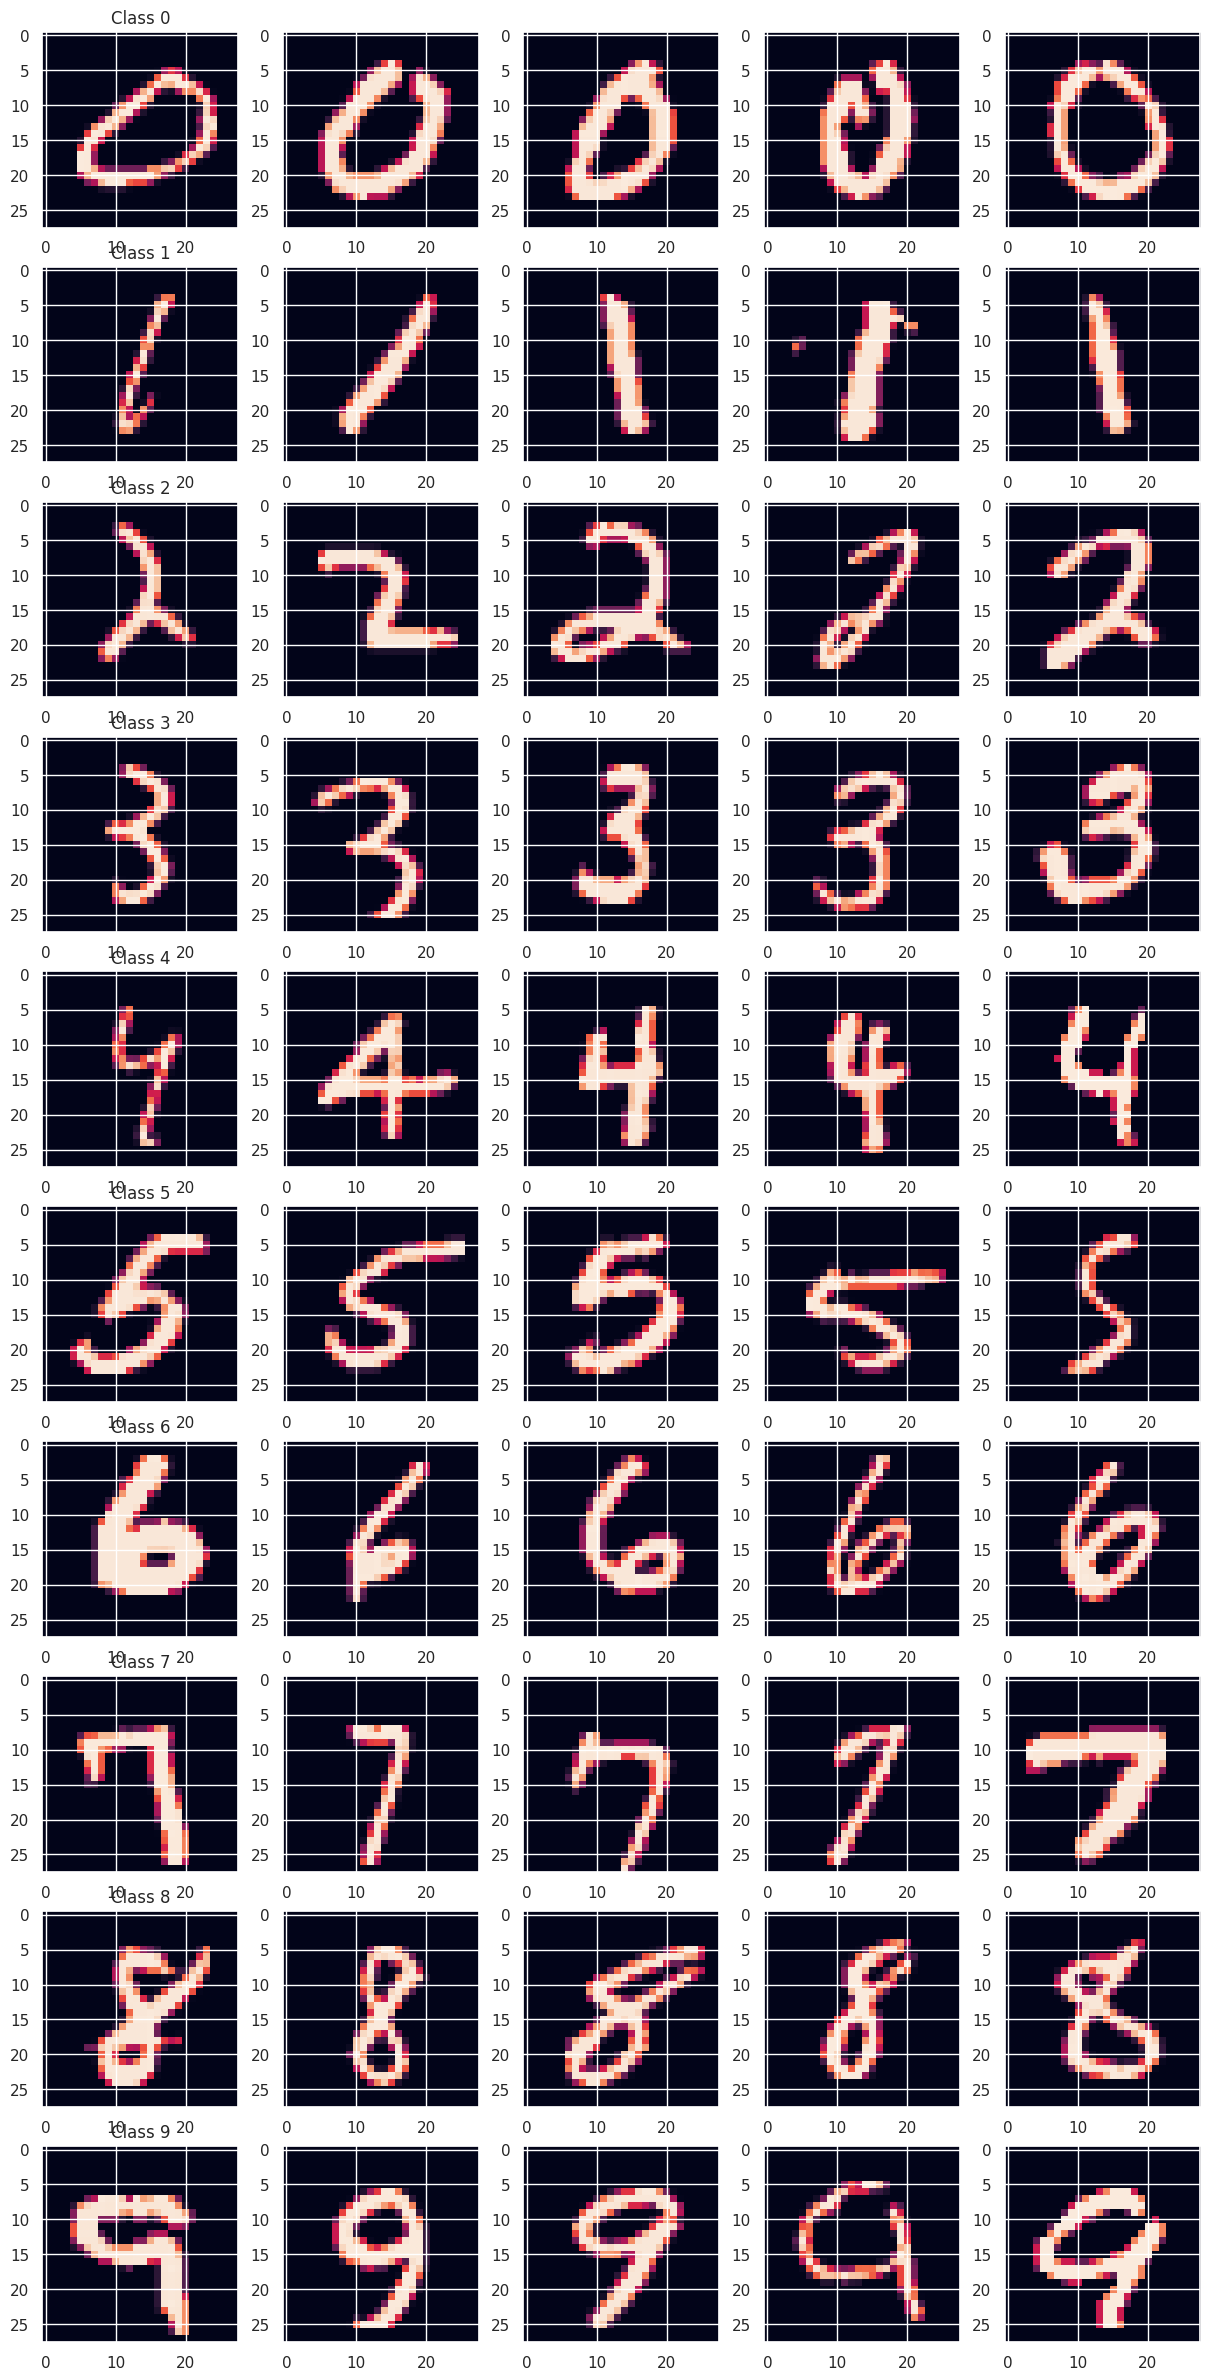

In [5]:
# YOUR CODE HERE
# 1: Show the first training example in X_train_fashion
plt.figure(figsize=(4, 4))
plt.imshow(X_train_fashion[0])
plt.title(f'Label: {Y_train_fashion[0]}')
plt.show()

# 2: Show the first training example in X_train_digits
plt.figure(figsize=(4, 4))
plt.imshow(X_train_digits[0])
plt.title(f'Label: {Y_train_digits[0]}')
plt.show()

# 3: Display the first 5 images in X_train_digits for each class in Y_train_digits, arranged in a 10x5 grid
images = []
labels = []

for label in range(10):
    idxs = np.where(Y_train_digits == label)[0][:5]
    for idx in idxs:
        images.append(X_train_digits[idx])
        labels.append(label)

nrows, ncols = 10, 5
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 30))

indx = 0
for i in range(nrows):
    for j in range(ncols):
        axs[i, j].imshow(images[indx])
        if j == 0:
            axs[i, j].set_title(f'Class {labels[indx]}')
        indx += 1
plt.show()

### Step 4: Modeling

### <span style="color:chocolate">Exercise 2:</span> Define model (20 points)

1. Fill in the <span style="color:chocolate">build_model()</span> function below, including all the arguments listed in the function definition. Note: the activation function parameter is only for the the hidden layers; use the appropriate final classification function for the final layer.

In [6]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01,
                metric='accuracy'):
    """Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.
    metric: The desired metric.

    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    # YOUR CODE HERE
    # Layer 1: Input
    input_layer = tf.keras.layers.Input(shape=(28, 28, 1), name='Input')
    # Layer 2: Flatten: only reformats data
    next_input = tf.keras.layers.Flatten(name='Flatten')(input_layer)
    # Layers 3-specified amount: hidden dense layers
    for i, units in enumerate(hidden_layer_sizes):
        next_input = tf.keras.layers.Dense(units=units, activation=activation, name=f'fc_{i+1}')(next_input)
    # Dropout Layer: helps with computation time and overfitting
    next_input = tf.keras.layers.Dropout(rate=0.3, name='Dropout')(next_input)
    # Output Layer
    output_layer = tf.keras.layers.Dense(units=n_classes, activation='softmax', name='Output')(next_input)
    # Instantiate the Model:
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    # If/Else block depending on user inputted Optimizer
    if optimizer.lower() == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer.lower() == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer: For given instructions, you must choose 'SGD' or 'Adam'.")
    # Compile the Model:
    model.compile(optimizer=opt,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=[metric])
    return model


---
### Step 5: Experiments

You can now run a suite of experiments to see how the hyperparameters and layer sizes effect model performance.

The <span style="color:chocolate">train_and_evaluate()</span> function below can be used to run experiments and retrieve results.

Training the digits model...


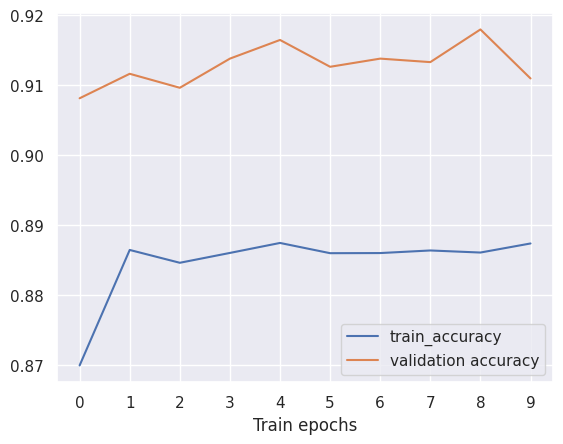

Training accuracy: 0.8874
Validation accuracy: 0.9110


In [7]:
def train_and_evaluate(data='digits',
                       hidden_layer_sizes=[],
                       activation='tanh',
                       optimizer='Adam',
                       learning_rate=0.01,
                       metric='accuracy',
                       num_epochs=10):

  # Build the model.
    model = build_model(n_classes=10,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      metric=metric,
                      learning_rate=learning_rate)

  # Select the dataset.
    if data == 'digits':
        X_train = X_train_digits
        X_test = X_test_digits
        Y_train = Y_train_digits
        Y_test = Y_test_digits

    elif data == 'fashion':
        X_train = X_train_fashion
        X_test = X_test_fashion
        Y_train = Y_train_fashion
        Y_test = Y_test_fashion
    else:
        raise 'Unsupported dataset: %s' %data

  # Train the model.
    print('Training the', data, 'model...')
    history = model.fit(
        x=X_train,
        y=Y_train,
        epochs=num_epochs,
        batch_size=64,
        validation_split=0.1,
        verbose=0)

    # Retrieve the training metrics (after each train epoch) and the final validation
    # accuracy.
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(val_accuracy, label='validation accuracy')
    plt.xticks(range(num_epochs))
    plt.xlabel('Train epochs')
    plt.legend()
    plt.show()

    print('Training accuracy: %1.4f' %train_accuracy[-1])
    print('Validation accuracy: %1.4f' %val_accuracy[-1])

    return model, train_accuracy[-1], val_accuracy[-1]


# run the function
model = train_and_evaluate()

### <span style="color:chocolate">Exercise 3:</span> Ablation study (50 points)

1. Conduct experiments and record the training and validation set accuracy results in the table below. You may extend the table for additional experiments as needed.
2. Report the hyperparameter values for your preferred architecture configuration.
3. Run the model once more using your preferred hyperparameter configuration.

NOTE: THE VALUES LISTED IN THE TABLE BELOW DIFFER SLIGHTLY FROM THE VALUES PRINTED AFTER THE CODE CELL AS THE MODEL WILL PERFORM SLIGHTLY WORSE/BETTER EVERY TIME IT IS RUN.

Data | Hidden sizes | Activation| Optimizer | Learning rate | #Parameters | Training accuracy| Validation accuracy
-|-|-|-|-|-|-|-
 digits | [] | tanh | SGD |0.01| 7850 | 0.8790 | 0.9000
 digits | [] | relu | SGD |0.01| 7850 | 0.8809 | 0.9013
 digits | [] | relu | Adam |0.01| 7850 | 0.8867 | 0.9128
 digits | [128] | relu | Adam |0.01| 101770 | 0.9529 | 0.9688
 digits | [256, 128] | relu | Adam |0.01| 235146 | 0.9665 | 0.9580
-|-|-|-|-|-|-|-
 fashion | [] | tanh | SGD |0.01| 7850 | 0.8109 | 0.8190
 fashion | [] | relu | SGD |0.01| 7850 | 0.8115 | 0.8212
 fashion | [] | relu | Adam |0.01| 7850 | 0.7997 | 0.8173
 fashion | [128] | relu | Adam |0.01| 101770 | 0.8242 | 0.8518
 fashion | [256, 128] | relu | Adam |0.01| 235146 | 0.8592 | 0.8498

Training the digits model...


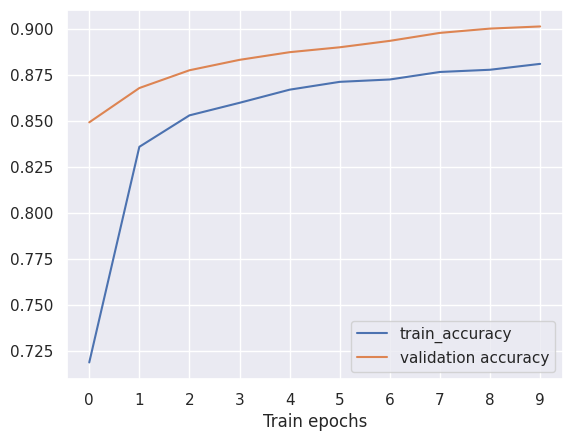

Training accuracy: 0.8810
Validation accuracy: 0.9013
Training the digits model...


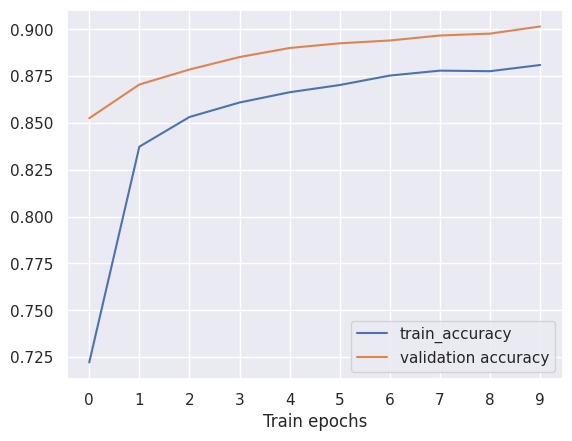

Training accuracy: 0.8809
Validation accuracy: 0.9015
Training the digits model...


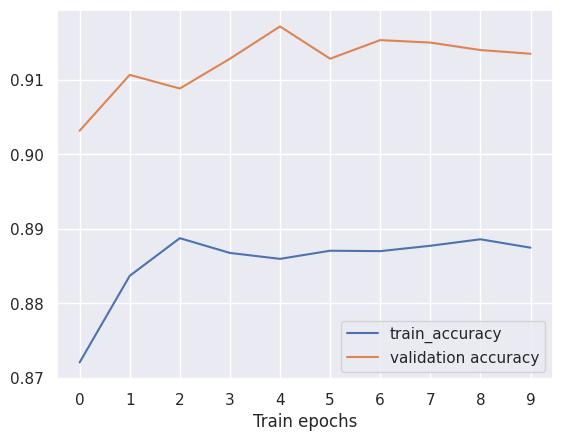

Training accuracy: 0.8875
Validation accuracy: 0.9135
Training the digits model...


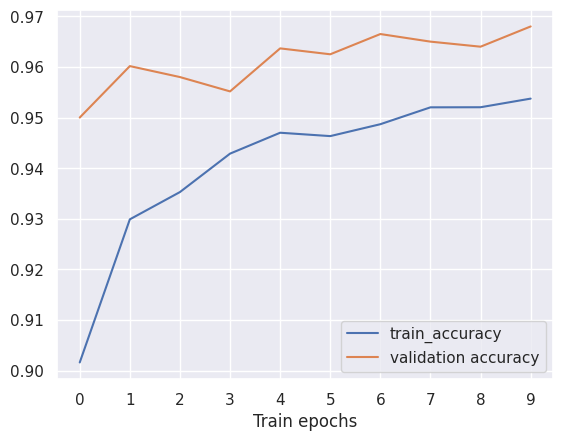

Training accuracy: 0.9537
Validation accuracy: 0.9680
Training the digits model...


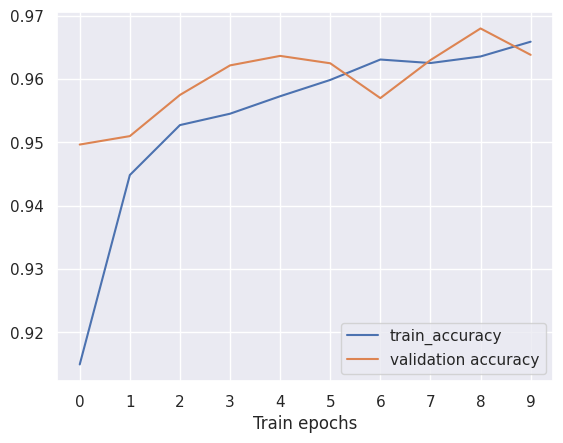

Training accuracy: 0.9659
Validation accuracy: 0.9638
Training the fashion model...


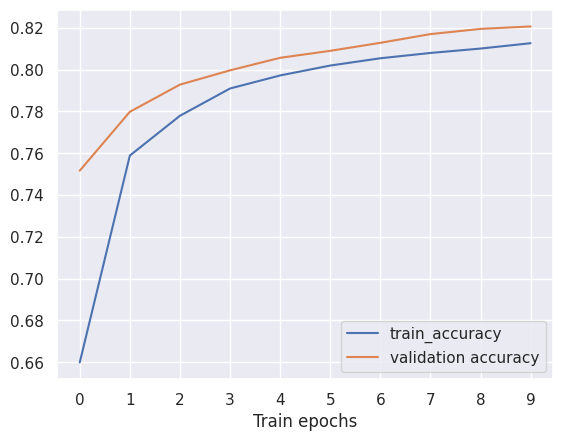

Training accuracy: 0.8126
Validation accuracy: 0.8207
Training the fashion model...


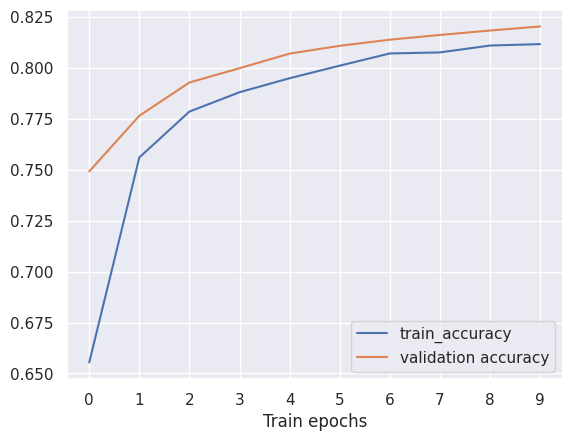

Training accuracy: 0.8117
Validation accuracy: 0.8203
Training the fashion model...


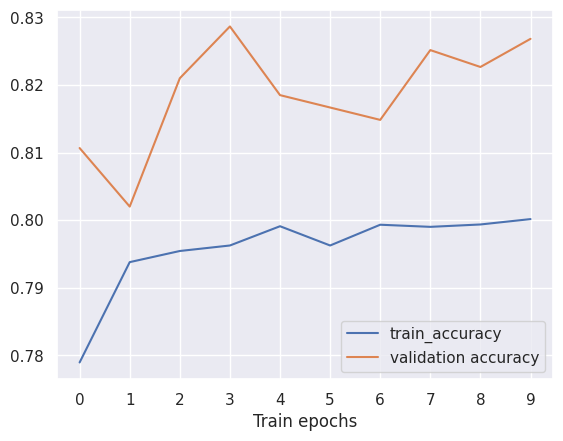

Training accuracy: 0.8001
Validation accuracy: 0.8268
Training the fashion model...


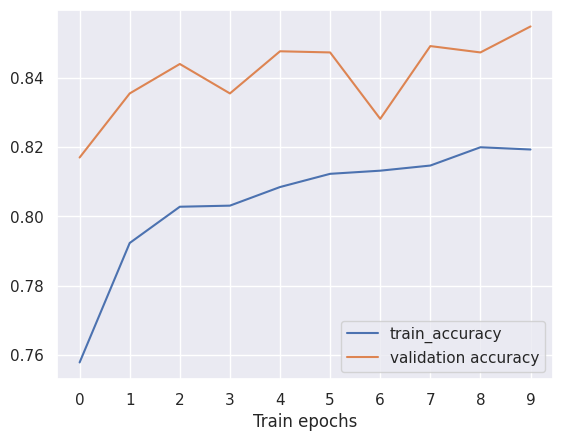

Training accuracy: 0.8193
Validation accuracy: 0.8548
Training the fashion model...


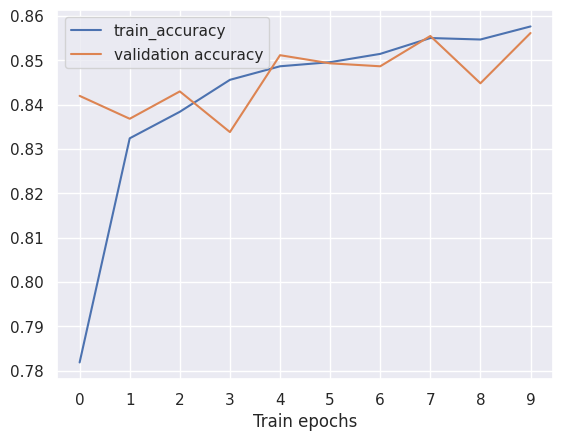

Training accuracy: 0.8576
Validation accuracy: 0.8562


,Data,Hidden sizes,Activation,Optimizer,Learning rate,#Parameters,Training accuracy,Validation accuracy
0,digits,[],tanh,SGD,0.01,7850,0.880982,0.901333
1,digits,[],relu,SGD,0.01,7850,0.880907,0.901500
2,digits,[],relu,Adam,0.01,7850,0.887463,0.913500
3,digits,[128],relu,Adam,0.01,101770,0.953741,0.968000
4,digits,"[256, 128]",relu,Adam,0.01,235146,0.965907,0.963833
5,fashion,[],tanh,SGD,0.01,7850,0.812648,0.820667
6,fashion,[],relu,SGD,0.01,7850,0.811667,0.820333
7,fashion,[],relu,Adam,0.01,7850,0.800148,0.826833
8,fashion,[128],relu,Adam,0.01,101770,0.819315,0.854833
9,fashion,"[256, 128]",relu,Adam,0.01,235146,0.857648,0.856167


In [8]:
# YOUR CODE HERE

# 1: See Dataframe Output
# Defining the experiments:
experiments = [
    ('digits', [], 'tanh', 'SGD', 0.01, 7850),
    ('digits', [], 'relu', 'SGD', 0.01, 7850),
    ('digits', [], 'relu', 'Adam', 0.01, 7850),
    ('digits', [128], 'relu', 'Adam', 0.01, 101770),
    ('digits', [256, 128], 'relu', 'Adam', 0.01, 235146),
    ('fashion', [], 'tanh', 'SGD', 0.01, 7850),
    ('fashion', [], 'relu', 'SGD', 0.01, 7850),
    ('fashion', [], 'relu', 'Adam', 0.01, 7850),
    ('fashion', [128], 'relu', 'Adam', 0.01, 101770),
    ('fashion', [256, 128], 'relu', 'Adam', 0.01, 235146),
]

# Storing the results:
results = []

# Running experiments:
# Editedd train_and_evaluate function to return the accuracy scores as well
for data, hidden_sizes, activation, optimizer, lr, params in experiments:
    model, train_acc, val_acc = train_and_evaluate(data=data,
                                                   hidden_layer_sizes=hidden_sizes,
                                                   activation=activation,
                                                   optimizer=optimizer,
                                                   learning_rate=lr,
                                                   num_epochs=10)

    results.append([data, hidden_sizes, activation, optimizer, lr, params, train_acc, val_acc])

# Converting results into a DataFrame
df_results = pd.DataFrame(results, columns=[
    'Data', 'Hidden sizes', 'Activation', 'Optimizer', 'Learning rate',
    '#Parameters', 'Training accuracy', 'Validation accuracy'
])
df_results

For both Digits and Fashion data, the preferred architecture configuration is as follows:
Hidden Layers: [256, 128] | Activation Function: ReLU | Optimizer: Adam | Learning Rate: 0.01 | #Parameters: 235,146
Training the digits model...


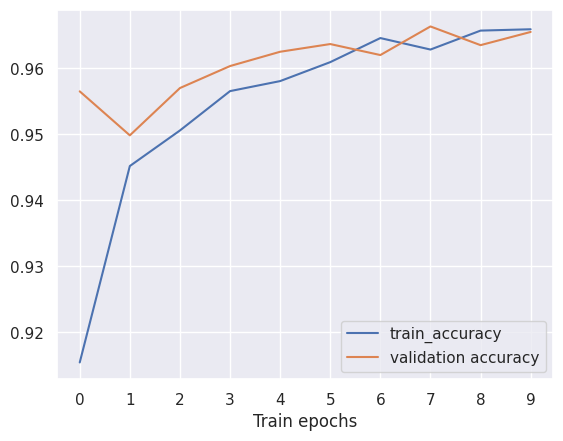

Training accuracy: 0.9659
Validation accuracy: 0.9655
Training the fashion model...


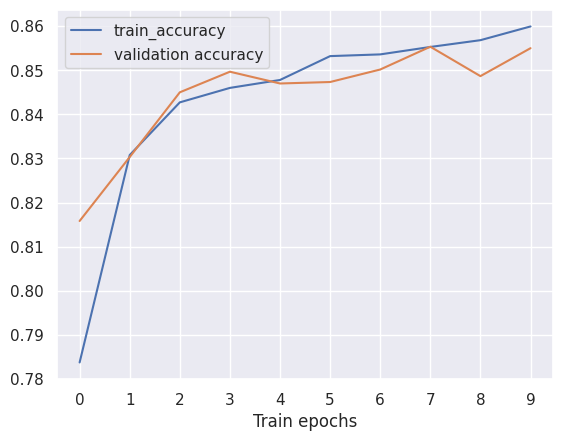

Training accuracy: 0.8599
Validation accuracy: 0.8550
Digits Dataset - Training Accuracy: 0.9659 | Validation Accuracy: 0.9655
Fashion Dataset - Training Accuracy: 0.8599 | Validation Accuracy: 0.8550


In [10]:
# 2: Report the hyperparameter values for your preferred architecture configuration:
print("For both Digits and Fashion data, the preferred architecture configuration is as follows:\nHidden Layers: [256, 128] | Activation Function: ReLU | Optimizer: Adam | Learning Rate: 0.01 | #Parameters: 235,146")

# 3: Run the model once more using your preferred hyperparameter configuration:
# Digits Dataset:
modelD, train_accD, val_accD = train_and_evaluate(
    data='digits',
    hidden_layer_sizes=[256, 128],
    activation='relu',
    optimizer='Adam',
    learning_rate=0.01,
    num_epochs=10
)
# Fashion Dataset:
modelF, train_accF, val_accF = train_and_evaluate(
    data='fashion',
    hidden_layer_sizes=[256, 128],
    activation='relu',
    optimizer='Adam',
    learning_rate=0.01,
    num_epochs=10
)
print(f"Digits Dataset - Training Accuracy: {train_accD:.4f} | Validation Accuracy: {val_accD:.4f}")
print(f"Fashion Dataset - Training Accuracy: {train_accF:.4f} | Validation Accuracy: {val_accF:.4f}")


---
### Step 6: Evaluation and Generalization

### <span style="color:chocolate">Exercise 4:</span> Compute metrics (25 points)

Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

1. Calculate accuracy on both train and test datasets. Note: you will need to convert the vector of predicted probabilities to a class label using the argmax operation. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method provided by tf.keras and the <span style="color:chocolate">np.max()</span> method available in NumPy; or you can use the <span style="color:chocolate">model.evaluare()</span> method provided by tf.keras directly.

2. Does the model demonstrate strong generalization capabilities? Provide an explanation based on your accuracy observations.

In [12]:
# YOUR CODE HERE

# 1. Accuracy for both train and test datasets for digits dataset:
test_lossD, test_accuracyD = modelD.evaluate(X_test_digits, Y_test_digits, verbose=0)
train_lossD, train_accuracyD = modelD.evaluate(X_train_digits, Y_train_digits, verbose=0)
print(f"Digits - Train Accuracy: {train_accuracyD:.4f} | Test Accuracy: {test_accuracyD:.4f}")

# Accuracy for both train and test datasets for fashion dataset:
test_lossF, test_accuracyF = modelF.evaluate(X_test_fashion, Y_test_fashion, verbose=0)
train_lossF, train_accuracyF = modelF.evaluate(X_train_fashion, Y_train_fashion, verbose=0)
print(f"Fashion - Train Accuracy: {train_accuracyF:.4f} | Test Accuracy: {test_accuracyF:.4f}")

# 2. Generalization:
print(f"The models demonstrate strong generalization capabilities, as the training and test accuracies are very close (and high/model is performing well), with a {abs(train_accuracyD - test_accuracyD) / train_accuracyD * 100:.4f}% difference for Digits data and a {abs(train_accuracyF - test_accuracyF) / train_accuracyF * 100:.4f}% difference for Fashion data.")


Digits - Train Accuracy: 0.9770 | Test Accuracy: 0.9689
Fashion - Train Accuracy: 0.8714 | Test Accuracy: 0.8508
The models demonstrate strong generalization capabilities, as the training and test accuracies are very close (and high/model is performing well), with a 0.8324% difference for Digits data and a 2.3640% difference for Fashion data.
